# Objective: determine probability of winning X times before losing Y times

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# I'm calling the class 'tourney' because this is meant to resemble a person or team's chance of
# winning/losing in some kind of elimination tournament

class tourney(object):
    
    def __init__(self, maxwins, maxlosses, pwin=0.5):
        self.win = maxwins
        self.loss = maxlosses
        self.winarr, self.lossarr = self.__pstopatwinloss(maxwins, maxlosses, pwin)
        self.winpct, self.losspct = self.__topercent(self.winarr, self.lossarr)
        self.maxgames = maxwins + maxlosses - 1
        self.mingames = min(maxwins, maxlosses)
        
        self.test = self.__binomial(maxwins, maxlosses)
        
    def __binomial(self, n, k):
        """
        A simplified version of the binomial theroem: n!/(k!(n-k)!)
        Returns 0 if k < 0, n < 0, or n < k
        Returns: float
        """
        if k < 0 or n < 0 or n < k:
            return 0
        return np.math.factorial(n) / ( np.math.factorial(k) * np.math.factorial(n-k) )
    
    def __pkresults(self, n, k, p=0.5):
        """
        The probability that exactly k outcomes of an event will result from n 
        events where p is the probability of successful k for each event

        Params:
        n:  number of events
        k:  number of 'desirable' outcomes
        p:  probability of success of k for each event, defaults to 0.5

        Returns: float
        """
        return self.__binomial(n-1, n-k) * np.power(p, k) * np.power(1-p, n-k)
        
    def __pstopatwinloss(self, win, loss, pwin=0.5):
    
        nmax = win + loss
        winarr = np.empty(nmax)
        lossarr = np.empty(nmax)

        for n in range(nmax):
            winarr[n] = self.__pkresults(n, win, pwin)
            lossarr[n] = self.__pkresults(n, loss, 1-pwin)

        return winarr, lossarr
    
    def __topercent(self, winarr, lossarr):
        toprcnt = lambda x: round(x * 100, 1)
        winarr = np.vectorize(toprcnt)(self.winarr)
        lossarr = np.vectorize(toprcnt)(self.lossarr)
        
        return winarr, lossarr
        
    def printwinlosstable(self):
        
        tpct = self.winpct + self.losspct
        wincs = self.winpct.cumsum()
        losscs = self.losspct.cumsum()
        tcs = tpct.cumsum()
        games = range(self.maxgames + 1)
    
        print(f'probability reach {self.win} wins', f'probability reach {self.loss} losses', 'probability reach win or loss condition', sep='\t')
        print('')
        print('game', 'pwin', 'wincs', '', 'game', 'ploss', 'losscs', '', 'game', 'pstop', 'tcs', sep='\t')

        for w, l, t, wcs, lcs, tcs, n in zip(self.winpct, self.losspct, tpct, wincs, losscs, tcs, games):
            print(n, w, wcs, '', n, l, lcs, '', n, t, tcs, sep='\t')
        
    def plotstopcondition(self, figwidth=12, figheight=4):
        
        games = range(self.maxgames + 1)
        ylim = max(self.winpct.max(), self.losspct.max())
        
        fig, ax = plt.subplots(figsize=(figwidth, figheight))
        
        ax.plot(games, self.winpct, '-o', linewidth=3)
        ax.plot(games, self.losspct, '-o', linewidth=3)
        ax.set_ylim(0 - 1, ylim + 1)
        ax.set_xlim(0, self.maxgames)
        
        ax.legend([f'win  {self.win}', f'loss {self.loss}'])
        ax.set_title('Probability of stopping due to condition being met')
        ax.set_xlabel('Game number')
        ax.set_ylabel('Probability (%)')

        fig.tight_layout()
        
    def __plotwinloss(self, stopcondition, stoptype, figwidth=12, figheight=4):
        
        if not stopcondition in ['win', 'loss']:
            print('Error: stopcondition parameter must be either "win" or "loss"')
            return
        
        if not stoptype in ['exact', 'atleast']:
            print('Error: stoptype parameter must be either "exact" or "atleast"')
            return
        
        if stopcondition == 'win':
            pstop = self.losspct[self.loss:]
            xlim = self.win
            title = 'winning'
            xlabel = 'won'
        else:
            pstop = self.winpct[self.win:]
            xlim = self.loss
            title = 'losing'
            xlabel = 'lost'
        
        if stoptype == 'exact':
            pstop = np.concatenate([pstop, [100 - pstop.sum()]])
            ymin = -1
            ymax = pstop.max() + 1
            xannmod = 0
            yannmod = -2
            suffix = 'exactly n games'
        else:
            pstop = np.concatenate([pstop.cumsum(), [100]])
            ymin = -5
            ymax = 105
            xannmod = -0.1
            yannmod = -10
            suffix = 'n games or less'
        
        games = range(len(pstop))
        
        fig, ax = plt.subplots(figsize=(figwidth, figheight))
        
        ax.plot(games, pstop, '-o', linewidth=3)
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(0, xlim)
        
        for xy in zip(games, pstop):
            ax.annotate(f'{round(xy[1], 1)}%', xy=xy, xytext=(xy[0] + xannmod, xy[1] - yannmod))
         
        ax.set_title(f'Probability of {title} {suffix}')
        ax.set_xlabel(f'Games {xlabel}')
        ax.set_ylabel('Probability (%)')

        fig.tight_layout() 
    
    def plotwinexact(self, figwidth=12, figheight=4):
        self.__plotwinloss('win', 'exact', figwidth, figheight)
        
    def plotlossexact(self, figwidth=12, figheight=4):
        self.__plotwinloss('loss', 'exact', figwidth, figheight)
        
    def plotwinatleast(self, figwidth=12, figheight=4):
        self.__plotwinloss('win', 'atleast', figwidth, figheight)
        
    def plotlossatleast(self, figwidth=12, figheight=4):
        self.__plotwinloss('loss', 'atleast', figwidth, figheight)
    

## Basic test of class

probability reach 9 wins	probability reach 3 losses	probability reach win or loss condition

game	pwin	wincs		game	ploss	losscs		game	pstop	tcs
0	0.0	0.0		0	0.0	0.0		0	0.0	0.0
1	0.0	0.0		1	0.0	0.0		1	0.0	0.0
2	0.0	0.0		2	0.0	0.0		2	0.0	0.0
3	0.0	0.0		3	12.5	12.5		3	12.5	12.5
4	0.0	0.0		4	18.8	31.3		4	18.8	31.3
5	0.0	0.0		5	18.8	50.1		5	18.8	50.1
6	0.0	0.0		6	15.6	65.7		6	15.6	65.7
7	0.0	0.0		7	11.7	77.4		7	11.7	77.4
8	0.0	0.0		8	8.2	85.6		8	8.2	85.6
9	0.2	0.2		9	5.5	91.1		9	5.7	91.3
10	0.9	1.1		10	3.5	94.6		10	4.4	95.7
11	2.2	3.3		11	2.2	96.8		11	4.4	100.1


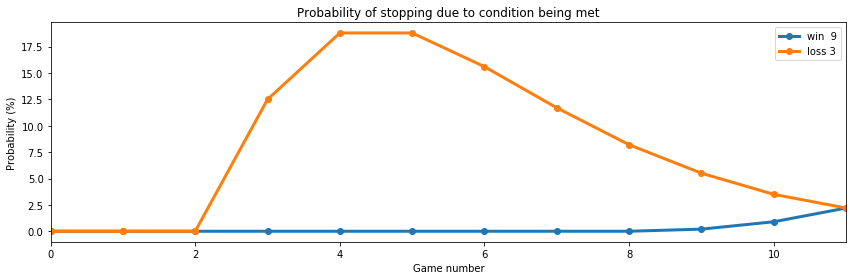

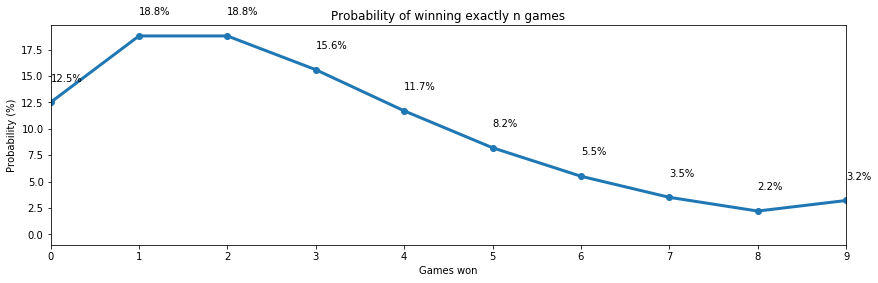

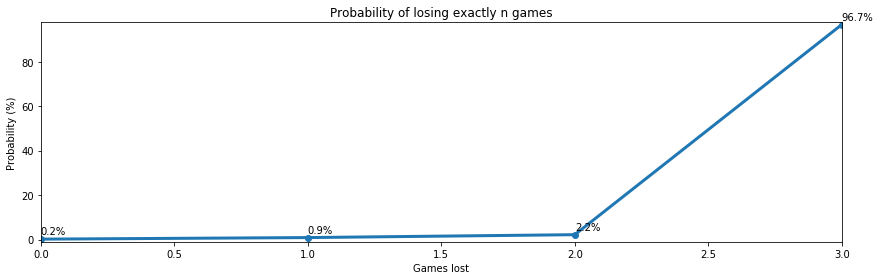

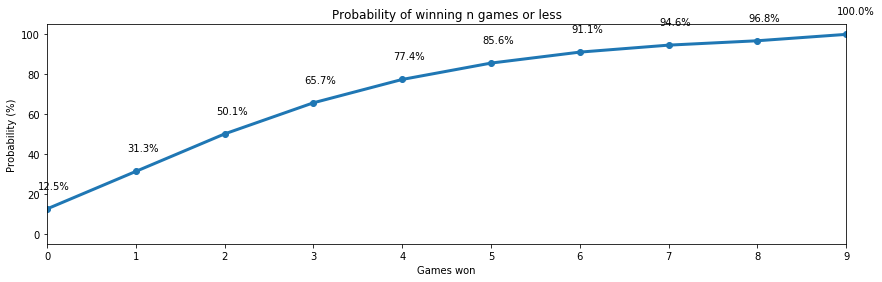

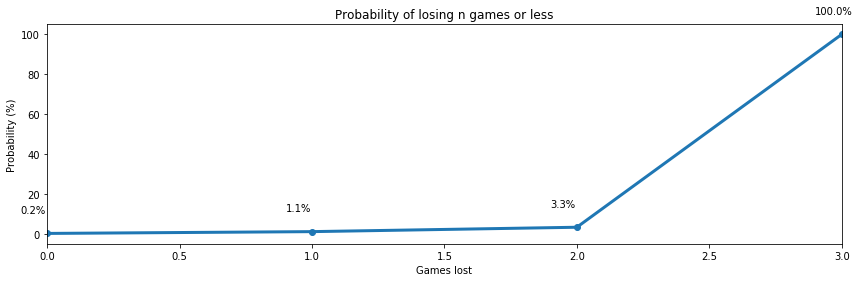

In [5]:
# First test, if either win 9 or lose 3, have to stop
x = tourney(9, 3, pwin=0.5)
x.printwinlosstable()
x.plotstopcondition()
x.plotwinexact()
x.plotlossexact()
x.plotwinatleast()
x.plotlossatleast()

probability reach 30 wins	probability reach 7 losses	probability reach win or loss condition

game	pwin	wincs		game	ploss	losscs		game	pstop	tcs
0	0.0	0.0		0	0.0	0.0		0	0.0	0.0
1	0.0	0.0		1	0.0	0.0		1	0.0	0.0
2	0.0	0.0		2	0.0	0.0		2	0.0	0.0
3	0.0	0.0		3	0.0	0.0		3	0.0	0.0
4	0.0	0.0		4	0.0	0.0		4	0.0	0.0
5	0.0	0.0		5	0.0	0.0		5	0.0	0.0
6	0.0	0.0		6	0.0	0.0		6	0.0	0.0
7	0.0	0.0		7	0.0	0.0		7	0.0	0.0
8	0.0	0.0		8	0.0	0.0		8	0.0	0.0
9	0.0	0.0		9	0.1	0.1		9	0.1	0.1
10	0.0	0.0		10	0.2	0.3		10	0.2	0.3
11	0.0	0.0		11	0.4	0.7		11	0.4	0.7
12	0.0	0.0		12	0.7	1.4		12	0.7	1.4
13	0.0	0.0		13	1.0	2.4		13	1.0	2.4
14	0.0	0.0		14	1.4	3.8		14	1.4	3.8
15	0.0	0.0		15	1.8	5.6		15	1.8	5.6
16	0.0	0.0		16	2.3	7.9		16	2.3	7.9
17	0.0	0.0		17	2.8	10.7		17	2.8	10.7
18	0.0	0.0		18	3.2	13.9		18	3.2	13.9
19	0.0	0.0		19	3.6	17.5		19	3.6	17.5
20	0.0	0.0		20	3.9	21.4		20	3.9	21.4
21	0.0	0.0		21	4.2	25.6		21	4.2	25.6
22	0.0	0.0		22	4.4	30.0		22	4.4	30.0
23	0.0	0.0		23	4.6	34.6		23	4.6	34.6
24	0.0	0.0		24	4.6	39.2		24	4.6

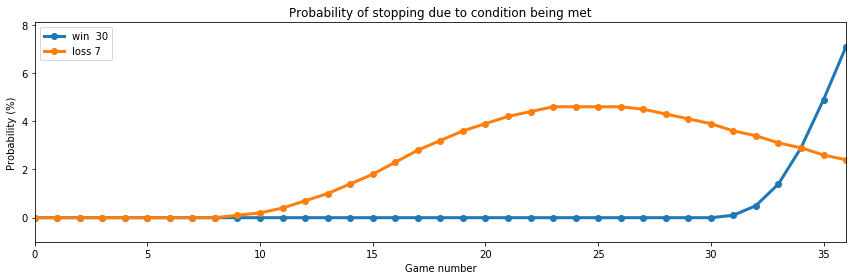

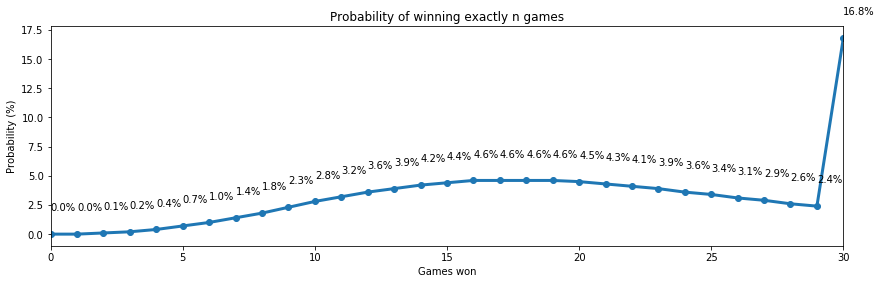

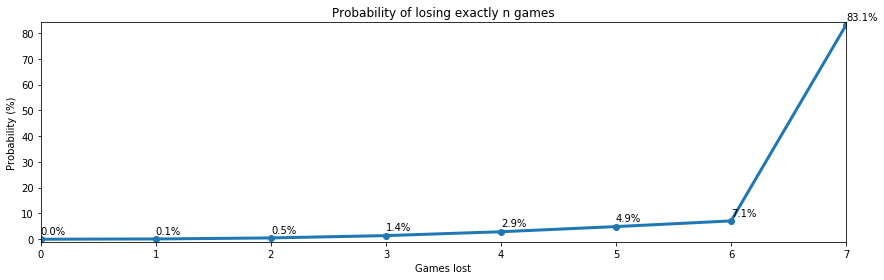

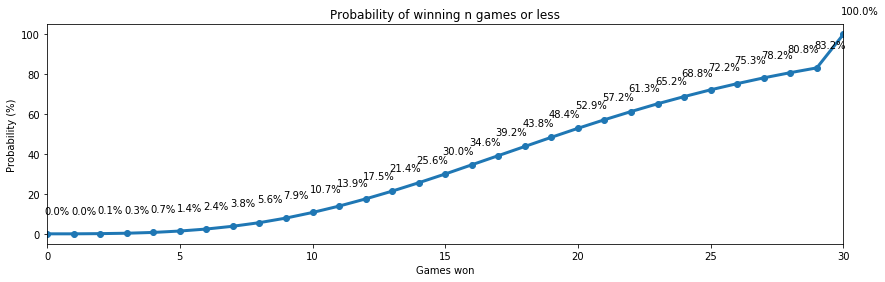

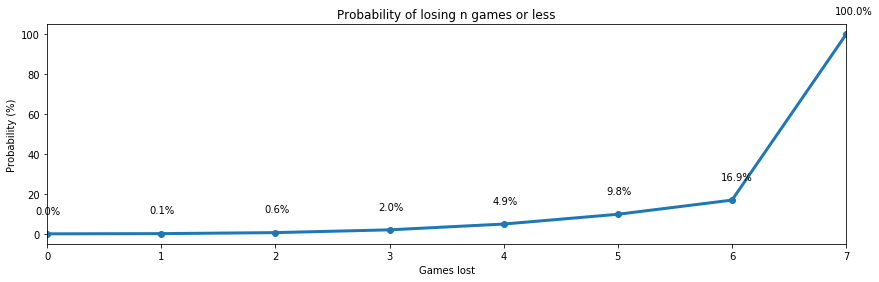

In [4]:
# Second test, win 30 or lose 7, pwin is 0.75
x = tourney(30, 7, pwin=0.75)
x.printwinlosstable()
x.plotstopcondition()
x.plotwinexact()
x.plotlossexact()
x.plotwinatleast()
x.plotlossatleast()

## Scrapyard

In [39]:
def binomial(n, k):
    """
    A simplified version of the binomial theroem: n!/(k!(n-k)!)
    Returns 0 if k < 0, n < 0, or n < k
    Returns: float
    """
    if k < 0 or n < 0 or n < k:
        return 0
    return np.math.factorial(n) / ( np.math.factorial(k) * np.math.factorial(n-k) )

In [67]:
def pkresults(n, k, p=0.5):
    """
    The probability that exactly k outcomes of an event will result from n 
    events where p is the probability of successful k for each event
    
    Params:
    n:  number of events
    k:  number of 'desirable' outcomes
    p:  probability of success of k for each event, defaults to 0.5
    
    Returns: float
    """
    return binomial(n-1, n-k) * np.power(p, k) * np.power(1-p, n-k)

In [71]:
def pstopatwinloss(win, loss):
    
    nmax = win + loss
    winarr = np.empty(nmax)
    lossarr = np.empty(nmax)
    
    for n in range(nmax):
        winarr[n] = pkresults(n, win)
        lossarr[n] = pkresults(n, loss)
    
    return winarr, lossarr

In [84]:
def printwinlosstable(winarr, lossarr):
    
    win = np.where(winarr != 0.0)[0][0]
    loss = np.where(lossarr != 0.0)[0][0]
    print(f'probability reach {win} wins', f'probability reach {loss} losses', 'probability reach win or loss condition', sep='\t')
    print('')
    print('game', 'pwin', 'wincs', '', 'game', 'ploss', 'losscs', '', 'game', 'pstop', 'tcs', sep='\t')
    
    topercent = lambda x: round(x * 100, 1)
    winarr = np.vectorize(topercent)(winarr)
    lossarr = np.vectorize(topercent)(lossarr)
    tarr = winarr + lossarr
    wincs = winarr.cumsum()
    losscs = lossarr.cumsum()
    tcs = tarr.cumsum()
    games = range(len(winarr))
    
    for w, l, t, wcs, lcs, tcs, n in zip(winarr, lossarr, tarr, wincs, losscs, tcs, games):
        print(n, w, wcs, '', n, l, lcs, '', n, t, tcs, sep='\t')

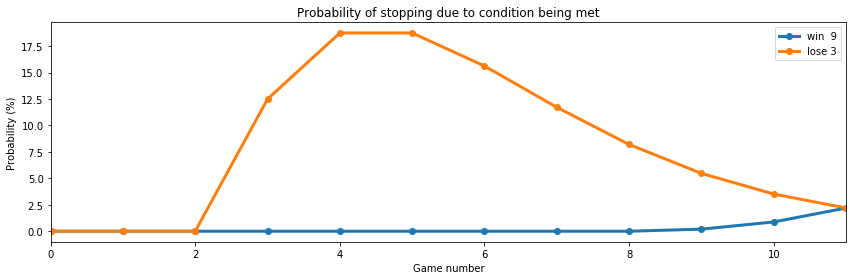

In [128]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(games, stop1, '-o', linewidth=3)
ax.plot(games, stop2, '-o', linewidth=3)
ax.set_ylim(0 - 1, ylim + 1)
ax.set_xlim(0, games[-1])
    
ax.legend([f'win  {win}', f'lose {loss}'])
ax.set_title('Probability of stopping due to condition being met')
ax.set_xlabel('Game number')
ax.set_ylabel('Probability (%)')

fig.tight_layout()

In [105]:
stop1 = stop1arr * 100
stop2 = stop2arr * 100
ylim = max(stop1.max(), stop2.max())
games = np.arange(len(stop1arr))

In [127]:
lower = min(win, loss)
lowstop = stop1 if lower == win else stop2
total = lowstop.sum()
lowstop = lowstop[lower:]
lowstop = np.concatenate([lowstop, [100 - total]])

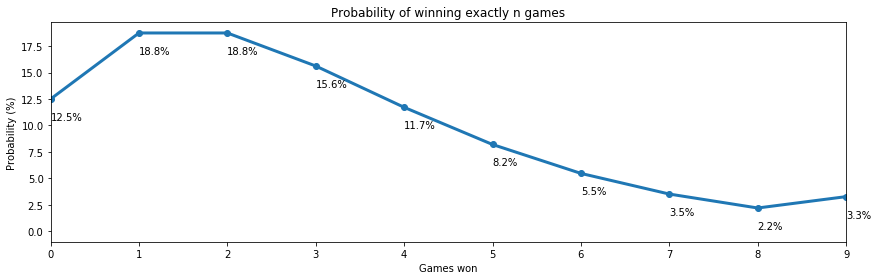

In [170]:
fig, ax = plt.subplots(figsize=(12,4))

wingames = np.arange(len(lowstop))
ax.plot(wingames, lowstop, '-o', linewidth=3)
ax.set_ylim(0 - 1, ylim + 1)
ax.set_xlim(0, wingames[-1])
for xy in zip(wingames, lowstop):
    ax.annotate(f'{round(xy[1], 1)}%', xy=xy, xytext=(xy[0], xy[1]-2))

ax.set_title('Probability of winning exactly n games')
ax.set_xlabel('Games won')
ax.set_ylabel('Probability (%)')

fig.tight_layout()

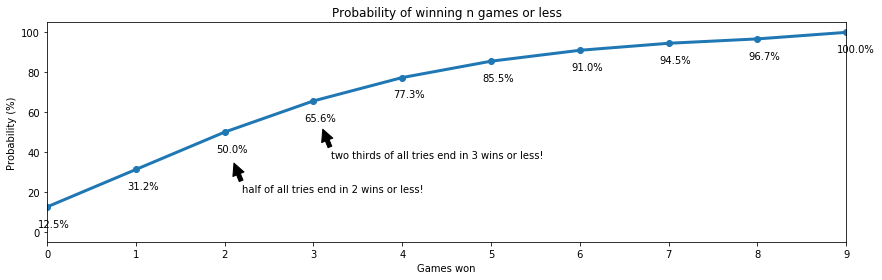

In [169]:
fig, ax = plt.subplots(figsize=(12,4))

understop = np.cumsum(lowstop)
ax.plot(wingames, understop, '-o', linewidth=3)
ax.set_xlim(0, wingames[-1])
ax.set_ylim(-5, 105)

for xy in zip(wingames, understop):
    ax.annotate(f'{round(xy[1], 1)}%', xy=xy, xytext=(xy[0]-0.1, xy[1]-10))
ax.annotate('half of all tries end in 2 wins or less!', 
            xy=(2.1, 35), xytext=(2.2, 20), arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('two thirds of all tries end in 3 wins or less!', 
            xy=(3.1, 52), xytext=(3.2, 37), arrowprops=dict(facecolor='black', shrink=0.05))
    
ax.set_title('Probability of winning n games or less')
ax.set_xlabel('Games won')
ax.set_ylabel('Probability (%)')

fig.tight_layout()